In [42]:
import numpy as np
import pandas as pd
import pymysql
import sqlalchemy as sql
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
from scipy.interpolate import interp1d

class NGLiveDataObject():
    
    def __init__(self, host, database, user, password):
        self.password = password
        self.host = host
        self.database = database
        self.user = user
        
    def get_from_database(self, query):
        """
        Connects to the storage database and retrieves the data for the given date.
        INPUT:
            - query: SQL query as string
        OUTPUT:
            - pandas dataframe
        """
        connect_string = 'mysql+pymysql://%(user)s:%(pw)s@%(host)s/%(db)s'% {
            "user": self.user, 
            "pw": self.password, 
            "host": self.host, 
            "db": self.database}
        
        sql_engine = sql.create_engine(connect_string)

        df = pd.read_sql(query, sql_engine)
        
        # convert to datetime
        df['time'] = pd.to_datetime(df['time'])
        # set index as time
        df.set_index('time', drop=True, inplace=True)
        return df
    
    def correct_pressure(self, lookup_table_path, data_pressure):
        """
        Applies the correction to the pressure and computes pressure from voltage measured.
        INPUT:
            - lookup_table_path: path to the lookup table
            - data_pressure pandas dataframe with columns time, id, voltage_VC, voltage_IS
        OUTPUT:
            - pandas dataframe with corrected pressure
        """
        # correct the pressure that the arduino reads. This is done using the dose_lookup_table which relates the pi dose with the displayed dose.
        df_LT_pressure = pd.read_csv(lookup_table_path, delimiter="\t")
        interp_pressure_IS = interp1d(pd.to_numeric(df_LT_pressure['pressure_IS_pi']).values, pd.to_numeric(df_LT_pressure['pressure_IS_display']).values, fill_value='extrapolate')
        data_pressure['pressure_IS'] = 10 ** (1.667 * data_pressure['voltage_IS'] - 11.33)
        data_pressure['pressure_VC'] = 10 ** (1.667 * data_pressure['voltage_VC'] - 11.33)
        data_pressure['pressure_IS_corrected'] = interp_pressure_IS(data_pressure['pressure_IS'])
        
        return data_pressure
    
    def resample_10_seconds(self, df, cols):
        """
        Takes the a grouped df (grouped by day) and resamples the columns cols in 10s
        OUTPUT:
            - dataframe 
        """

        d = {}
        range_start = df.iloc[0].name
        range_end = df.iloc[-1].name
        # resample 24 hours in steps of 10 s
        s = pd.date_range(start=range_start, end=range_end, freq='10S')
        df_out = pd.DataFrame(pd.Series(s, name='time')).set_index('time')
        for col in cols:
            d[col] = df[col].resample('10S').mean()

        this_d = pd.DataFrame(d)

        df_out = df_out.merge(this_d, left_on=df_out.index, right_on=this_d.index, how='outer')
        df_out.set_index('key_0', drop=True, inplace=True)
        
        return df_out

# Get the data

In [43]:
# read password and user to database
credentials_file = '/Users/hkromer/02_PhD/01.github/dash_NG/credentials.pw'
credentials = pd.read_csv(credentials_file, header=0)
user = credentials['username'].values[0]
pw = credentials['password'].values[0]
host="twofast-RPi3-0"  # your host
user=user  # username
passwd=pw  # password
db="NG_twofast_DB" # name of the database




# connect to DB
con = NGLiveDataObject(host = host, database=db, user=user, password=pw)

# get HV
query = "SELECT * FROM HBox_Uno "
data_HV = con.get_from_database(query=query)
data_HV['HV_current_x100'] = data_HV['HV_current'] * 100.0

# convert dose voltage to dose
data_HV['dose'] = data_HV['dose_voltage'] * 3000 / 5.5

# get pressure
query = "SELECT * FROM BBox"
data_pressure = con.get_from_database(query=query)

# correct pressure
lookup_table_path = "/Users/hkromer/02_PhD/01.github/phd/01_neutron_generator_contol/LUT_pressure_ion_source.txt"
data_pressure = con.correct_pressure(lookup_table_path, data_pressure)



# Plot HV and dose in one plot

/Users/hkromer/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/hkromer/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


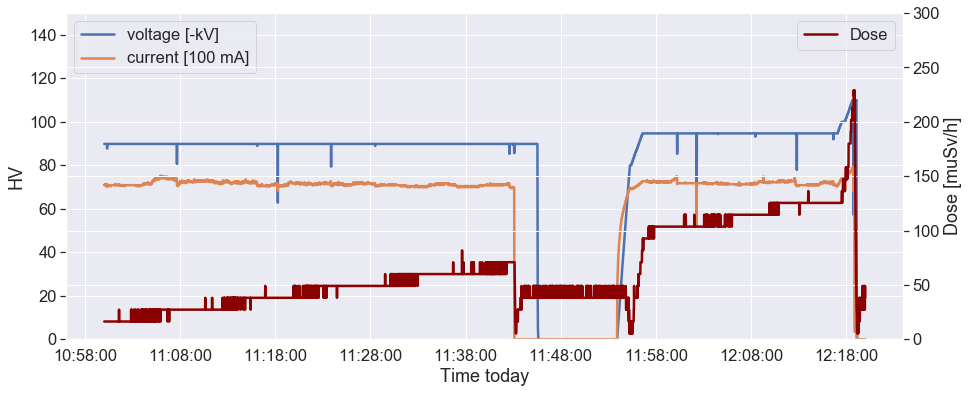

In [15]:
time_start = '2019-12-18 11:00:00'
time_end = '2019-12-18 12:20:00'

data_HV_t = data_HV.loc[time_start:time_end,:]


fig, ax = plt.subplots(figsize=(15,6))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# plot HV and current on the left
sns.lineplot(x=data_HV_t.index, y='HV_voltage', data=data_HV_t, ax=ax, label='voltage [-kV]')
sns.lineplot(x=data_HV_t.index, y='HV_current_x100', data=data_HV_t, ax=ax, label='current [100 mA]')
ax.set_ylabel('HV')
plt.legend(loc='upper left')

# plot dose on the right
ax2 = ax.twinx()
sns.lineplot(x=data_HV_t.index, y='dose', data=data_HV_t, ax=ax2, color='darkred', label='Dose')
plt.legend(loc='upper right')
ax2.set_ylabel('Dose [muSv/h]')

ax.set_xlabel(f'Time today')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
ax.set_ylim(0, 150)
ax2.set_ylim(0, 300)

# plt.savefig(f'{path}pressure_hv_day.png', dpi=1200, format='png')
plt.show()

# Save to a file with latex


/Users/hkromer/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


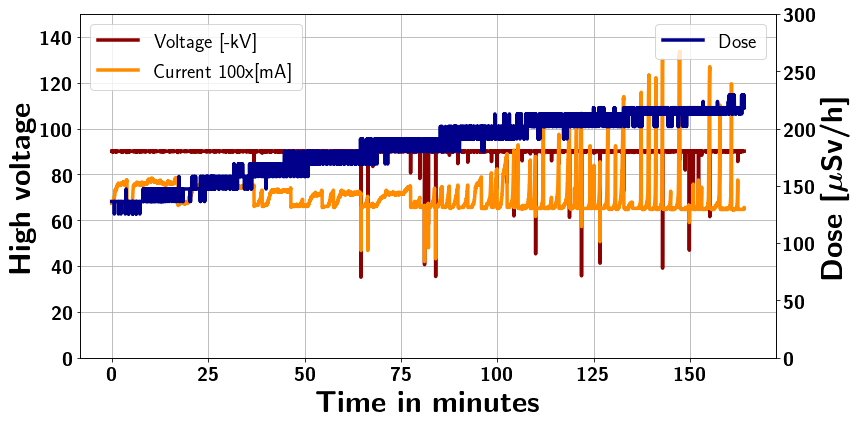

In [46]:
fname = '/Users/hkromer/02_PhD/04_Publiations/03_Presentations/2019/2019-12-17.Spiez/2019-12-18.first_neutrons.png'
datafname = '/Users/hkromer/02_PhD/04_Publiations/03_Presentations/2019/2019-12-17.Spiez/2019-12-18.first_neutrons.csv'
time_start = '2019-12-18 16:30:00'
time_end = '2019-12-18 20:00:00'

data_HV_t = data_HV.loc[time_start:time_end,:]
data_HV_t['HV_current_x100'] = data_HV_t['HV_current'] * 100.0
# one tick is one second
ticks = data_HV_t.shape[0]
data_HV_t = data_HV_t.reset_index()
data_HV_t['xlabel_minutes'] = data_HV_t.index / 60.0

# convert dose voltage to dose
data_HV_t['dose'] = data_HV_t['dose_voltage'] * 3000 / 5.5

# set the weird ones straight
# data_HV_t.loc[(data_HV_t['xlabel_minutes']>42) & (data_HV_t['xlabel_minutes']<57),'dose'] = 16

import matplotlib
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']



fig, ax = plt.subplots(figsize=(12,6))
fs = 30


# sns.lineplot(x=this_df_hv.index, y='HV_voltage', data=this_df_hv, ax=ax, color='darkred', label='voltage [-kV]')
ax.plot(data_HV_t['xlabel_minutes'].values, data_HV_t['HV_voltage'].values, color='darkred', label='Voltage [-kV]', linewidth=3.5)
# sns.lineplot(x=this_df_hv.index, y='HV_current_x100', data=this_df_hv, ax=ax, color='darkorange', label='current [100 mA]')
ax.plot(data_HV_t['xlabel_minutes'].values, data_HV_t['HV_current_x100'].values, color='darkorange', label='Current 100x[mA]', linewidth=3.5)
ax.legend(loc='upper left', fontsize=fs-10)
ax.set_xlabel(r'\textbf{Time in minutes}', fontsize=fs)
ax.set_ylabel(r'\textbf{High voltage}', fontsize=fs)

ax2 = ax.twinx()
ax2.plot(data_HV_t['xlabel_minutes'].values, data_HV_t['dose'].values, color='darkblue', label='Dose', linewidth=3.5)
ax2.set_ylabel(r'\textbf{Dose [$\mu$Sv/h]}', fontsize=fs)

# ax.set_xlabel(f'Time, {day}')
# ax.xaxis.set_major_formatter(md.DateFormatter(r'\textbf{%H:%M}'))
ax.tick_params(axis='both', which='major', labelsize=fs-10)
ax2.tick_params(axis='both', which='major', labelsize=fs-10)


ax2.legend(loc='upper right', fontsize=fs-10)
ax.set_ylim(0, 150)
ax2.set_ylim(0, 300)
ax.grid(b=True, which='major', linestyle='-')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
plt.savefig(f'{fname}', dpi=1200, format='png')
plt.show()
data_HV_t[['time','xlabel_minutes', 'HV_current', 'HV_voltage', 'dose', 'HV_current_x100']].to_csv(datafname)

## Same plot without current

/Users/hkromer/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


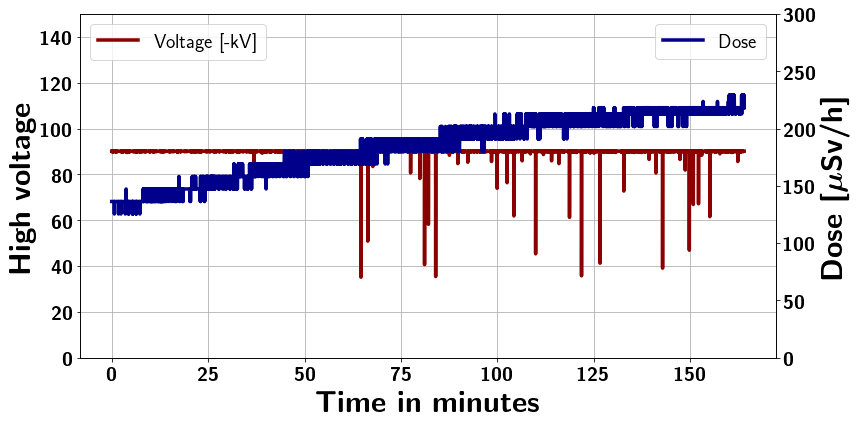

In [47]:
fname = '/Users/hkromer/02_PhD/04_Publiations/03_Presentations/2019/2019-12-17.Spiez/2019-12-18.first_neutrons.no_current.png'

time_start = '2019-12-18 16:30:00'
time_end = '2019-12-18 20:00:00'

data_HV_t = data_HV.loc[time_start:time_end,:]
data_HV_t['HV_current_x100'] = data_HV_t['HV_current'] * 100.0
# one tick is one second
ticks = data_HV_t.shape[0]
data_HV_t = data_HV_t.reset_index()
data_HV_t['xlabel_minutes'] = data_HV_t.index / 60.0

# convert dose voltage to dose
data_HV_t['dose'] = data_HV_t['dose_voltage'] * 3000 / 5.5

# set the weird ones straight
# data_HV_t.loc[(data_HV_t['xlabel_minutes']>42) & (data_HV_t['xlabel_minutes']<57),'dose'] = 16

import matplotlib
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']



fig, ax = plt.subplots(figsize=(12,6))
fs = 30


# sns.lineplot(x=this_df_hv.index, y='HV_voltage', data=this_df_hv, ax=ax, color='darkred', label='voltage [-kV]')
ax.plot(data_HV_t['xlabel_minutes'].values, data_HV_t['HV_voltage'].values, color='darkred', label='Voltage [-kV]', linewidth=3.5)
# sns.lineplot(x=this_df_hv.index, y='HV_current_x100', data=this_df_hv, ax=ax, color='darkorange', label='current [100 mA]')
# ax.plot(data_HV_t['xlabel_minutes'].values, data_HV_t['HV_current_x100'].values, color='darkorange', label='Current 100x[mA]', linewidth=3.5)
ax.legend(loc='upper left', fontsize=fs-10)
ax.set_xlabel(r'\textbf{Time in minutes}', fontsize=fs)
ax.set_ylabel(r'\textbf{High voltage}', fontsize=fs)

ax2 = ax.twinx()
ax2.plot(data_HV_t['xlabel_minutes'].values, data_HV_t['dose'].values, color='darkblue', label='Dose', linewidth=3.5)
ax2.set_ylabel(r'\textbf{Dose [$\mu$Sv/h]}', fontsize=fs)

# ax.set_xlabel(f'Time, {day}')
# ax.xaxis.set_major_formatter(md.DateFormatter(r'\textbf{%H:%M}'))
ax.tick_params(axis='both', which='major', labelsize=fs-10)
ax2.tick_params(axis='both', which='major', labelsize=fs-10)


ax2.legend(loc='upper right', fontsize=fs-10)
ax.set_ylim(0, 150)
ax2.set_ylim(0, 300)
ax.grid(b=True, which='major', linestyle='-')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
plt.savefig(f'{fname}', dpi=1200, format='png')
plt.show()
data_HV_t[['time','xlabel_minutes', 'HV_current', 'HV_voltage', 'dose', 'HV_current_x100']].to_csv(datafname)

# Plot pressure


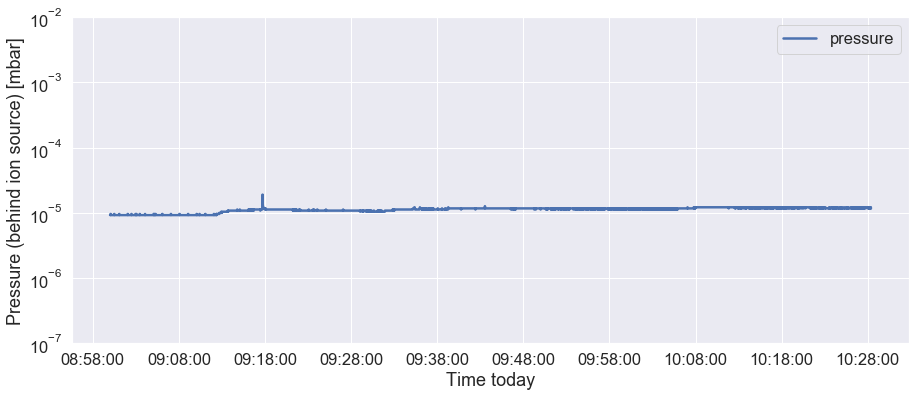

In [6]:
time_start = '2019-12-18 09:00:00'
time_end = '2019-12-18 14:30:00'

data_pressure_t = data_pressure.loc[time_start:time_end,:]

fig, ax = plt.subplots(figsize=(15,6))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

sns.lineplot(x=data_pressure_t.index, y='pressure_IS_corrected', data=data_pressure_t, ax=ax, label='pressure')

ax.set(yscale="log")
ax.set_ylabel('Pressure (behind ion source) [mbar]')

ax.set_xlabel(f'Time today')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
ax.set_ylim(1e-7, 1e-2)

# plt.savefig(f'{path}pressure_hv_day.png', dpi=1200, format='png')
plt.show()

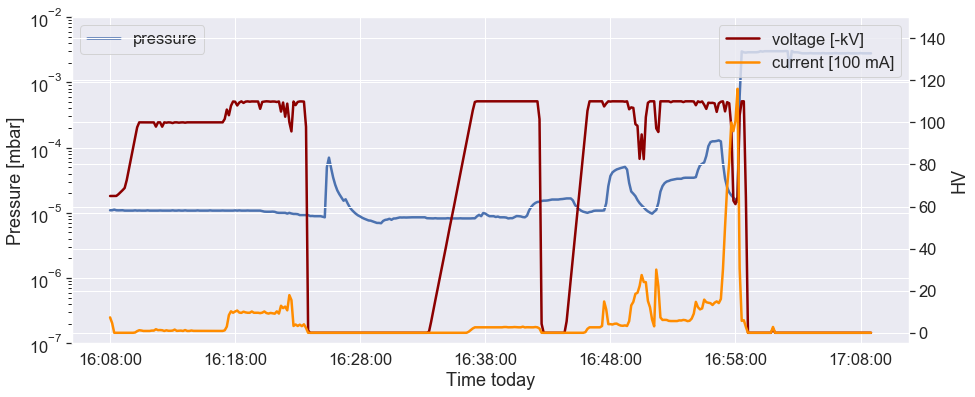

In [9]:
time_start = '2019-12-16 16:08:00'
time_end = '2019-12-16 19:20:00'

t_data_pressure = data_pressure.loc[time_start:time_end,:]
t_data_HV = data_HV.loc[time_start:time_end,:]


fig, ax = plt.subplots(figsize=(15,6))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

sns.lineplot(x=t_data_pressure.index, y='pressure_IS_corrected', data=t_data_pressure, ax=ax, label='pressure')
plt.legend(loc='upper left')

ax2 = ax.twinx()
sns.lineplot(x=t_data_HV.index, y='HV_voltage', data=t_data_HV, ax=ax2, color='darkred', label='voltage [-kV]')
sns.lineplot(x=t_data_HV.index, y='HV_current_x100', data=t_data_HV, ax=ax2, color='darkorange', label='current [100 mA]')
plt.legend(loc='upper right')

ax.set(yscale="log")
ax.set_ylabel('Pressure [mbar]')
ax2.set_ylabel('HV')

ax.set_xlabel(f'Time today')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
ax.set_ylim(1e-7, 1e-2)
ax2.set_ylim(-5, 150)

# plt.savefig(f'{path}pressure_hv_day.png', dpi=1200, format='png')
plt.show()